In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
pd.options.mode.chained_assignment = None

[Snowflake Dataset](https://github.com/resource-disaggregation/snowset)

## Process & Extract Dataset

In [2]:
# 03-01-2018:00:00:00 - 03-02-2018:00:00:00
start, end = 1519862400, 1519948800
N, T = 200, end - start
data_filename = f"snowflake_{start}-{end}.csv"

In [ ]:
def process_chunk(df, start, end):
    # Remove null values
    df = df[~df.eq(r"\N").any(axis=1)]
    # Convert string to timestamp
    df["createdTime"] = pd.to_datetime(df["createdTime"], format="mixed").astype("int64") / 1e9

    # Get all rows between start and end
    df = df[df["createdTime"].between(start, end, inclusive="left")]
    return df

In [ ]:
chunks = []
size = 0

with pd.read_csv("snowflake.gz", compression="gzip", chunksize=1e6, usecols=["databaseId", "createdTime", "durationTotal"], 
                 dtype={"databaseId": "object", "createdTime": "object", "durationTotal": "int64"}) as reader:
    for i, chunk in enumerate(reader):
        pchunk = process_chunk(chunk, start, end)
        chunks.append(pchunk)
        size += pchunk.shape[0]
        print(f"chunk {i}: len={pchunk.shape[0]}/{chunk.shape[0]}, total={size}")

df = pd.concat(chunks)

In [ ]:
df.to_csv(data_filename, index=False)

## Sample User Queries

In [3]:
df = pd.read_csv(data_filename)
df.shape

(5255032, 3)

In [4]:
all_users = list(df["databaseId"].unique())
len(all_users)

2644

In [5]:
users = random.sample(all_users, N)
df_users = df[df["databaseId"].isin(users)]
df_users.shape

(223883, 3)

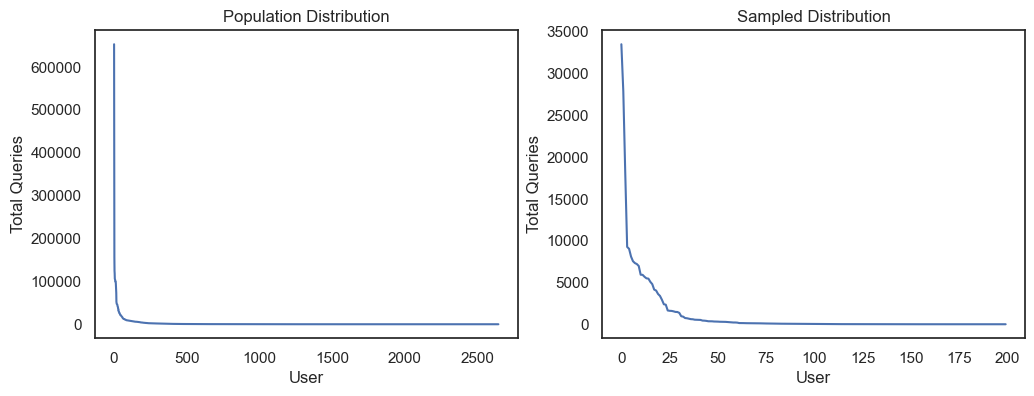

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(list(df["databaseId"].value_counts()))
plt.title("Population Distribution")
plt.xlabel("User")
plt.ylabel("Total Queries")

plt.subplot(1, 2, 2)
plt.plot(list(df_users["databaseId"].value_counts()))
plt.title("Sampled Distribution")
plt.xlabel("User")
plt.ylabel("Total Queries")
plt.show()

## Generate User Demand Matrix

In [7]:
df_users = df_users.sort_values(by="createdTime").reset_index(drop=True)
df_users.head()

,databaseId,createdTime,durationTotal
0,2768614462796934202,1.519862e+09,35736
1,7834499828131635729,1.519862e+09,45562
2,724013179981795114,1.519862e+09,87624
3,2768614462796934202,1.519862e+09,22148
4,9116806658341816169,1.519862e+09,307762


In [8]:
user_idx = {}
demands = np.zeros((T, N))

def update_demand(id, time, duration):
    if id not in user_idx:
        user_idx[id] = len(user_idx)
    
    idx = user_idx[id]
    s = int(time - start)
    end = min(s + math.ceil(duration / 1000), T)
    assert end > s

    for i in range(s, end):
        demands[i][idx] += 1

In [9]:
_ = df_users.apply(lambda row: update_demand(row["databaseId"], row["createdTime"], row["durationTotal"]), axis=1)
# np.savetxt("demands.txt", demands, fmt="%i")

In [10]:
# demands = np.loadtxt("demands.txt")
# demands *= 2
total_demands = np.sum(demands, axis=1)
user_demands = np.sort(np.sum(demands, axis=0))[::-1]

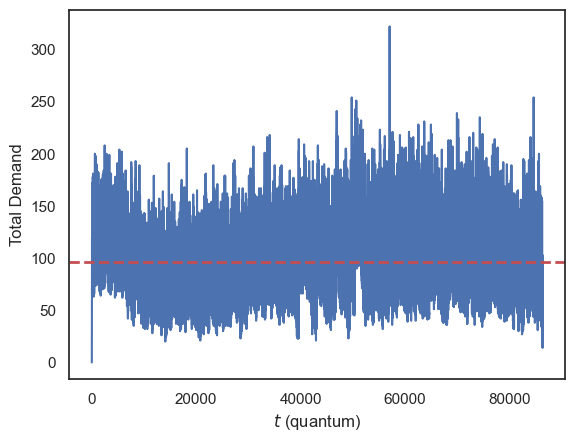

In [11]:
plt.plot(total_demands)
plt.axhline(np.mean(total_demands), c="r", ls="--", lw=2)
plt.xlabel("$t$ (quantum)")
plt.ylabel("Total Demand")
plt.show()

In [12]:
np.min(user_demands), np.median(user_demands), np.mean(user_demands), np.max(user_demands)

(1.0, 348.5, 41661.87, 2100039.0)

In [13]:
np.min(total_demands), np.median(total_demands), np.mean(total_demands), np.max(total_demands)

(0.0, 94.0, 96.43951388888888, 322.0)

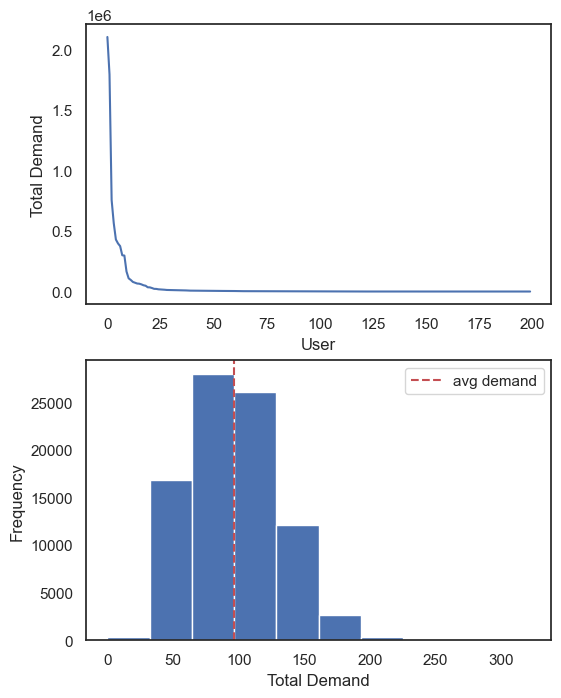

In [14]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(user_demands)
# plt.yscale("log")
plt.xlabel("User")
plt.ylabel("Total Demand")

plt.subplot(2, 1, 2)
plt.hist(total_demands)
plt.axvline(np.mean(total_demands), c="r", ls="--", label="avg demand")
plt.legend()
plt.xlabel("Total Demand")
plt.ylabel("Frequency")

plt.savefig("workload.png", bbox_inches="tight")
plt.show()